In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install torch==1.3.1
!pip install torchvision==0.4.2
!pip install Pillow==6.2.1
!pip install pennylane==0.7.0

     |████████████████████████████████| 734.6MB 22kB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.3.1 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
     |████████████████████████████████| 10.2MB 16.3MB/s 
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
     |████████████████████████████████| 2.1MB 17.5MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


     |████████████████████████████████| 163kB 18.7MB/s 


In [2]:
# OpenMP: number of parallel threads.
%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Other tools
import time
import copy

env: OMP_NUM_THREADS=1


In [3]:
filtered_classes = ['cat', 'dog']  # Subset of CIFAR ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
n_qubits = 4                       # Number of qubits
quantum = True                     # If set to "False", the dressed quantum circuit is replaced by 
                                   # An enterily classical net (defined by the next parameter). 
classical_model = '512_n'          # Possible choices: '512_n','512_nq_n','551_512_n'. [nq=n_qubits, n=num_filtered_classes]
step = 0.001                       # Learning rate
batch_size = 8                     # Number of samples for each training step
num_epochs = 3                     # Number of training epochs
q_depth = 5                        # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 1             # Learning rate reduction applied every 10 epochs.                       
max_layers = 15                    # Keep 15 even if not all are used.
q_delta = 0.01                     # Initial spread of random quantum weights
rng_seed = 0                       # Seed for random number generator
start_time = time.time()           # start of the computation timer

In [4]:
torch.manual_seed(rng_seed)

In [5]:
dev = qml.device('default.qubit', wires=n_qubits)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates. 
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)
        
def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis. 
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT  
    for i in range(0, nqubits - 1, 2): # Loop over even indices: i=0,2,...N-2  
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1,2): # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [8]:
@qml.qnode(dev, interface='torch')
def q_net(q_in, q_weights_flat):
        
        # Reshape weights
        q_weights = q_weights_flat.reshape(max_layers, n_qubits)
        
        # Start from state |+> , unbiased w.r.t. |0> and |1>
        H_layer(n_qubits)
        
        # Embed features in the quantum node
        RY_layer(q_in)
       
        # Sequence of trainable variational layers
        for k in range(q_depth):
            entangling_layer(n_qubits)
            RY_layer(q_weights[k+1])

        # Expectation values in the Z basis
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

In [9]:
class Quantumnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.pre_net = nn.Linear(512, n_qubits)
            self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))
            self.post_net = nn.Linear(n_qubits, len(filtered_classes))

        def forward(self, input_features):
            pre_out = self.pre_net(input_features) 
            q_in = torch.tanh(pre_out) * np.pi / 2.0   
            
            # Apply the quantum circuit to each element of the batch, and append to q_out
            q_out = torch.Tensor(0, n_qubits)
            q_out = q_out.to(device)
            for elem in q_in:
                q_out_elem = q_net(elem,self.q_params).float().unsqueeze(0)
                q_out = torch.cat((q_out, q_out_elem))
            return self.post_net(q_out)

In [10]:
class Quantumnet_Cut(nn.Module):
        def __init__(self):
            super().__init__()
            self.pre_net = nn.Linear(512, n_qubits)
            self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))

        def forward(self, input_features):
            pre_out = self.pre_net(input_features) 
            q_in = torch.tanh(pre_out) * np.pi / 2.0   
            
            # Apply the quantum circuit to each element of the batch, and append to q_out
            q_out = torch.Tensor(0, n_qubits)
            q_out = q_out.to(device)
            for elem in q_in:
                q_out_elem = q_net(elem,self.q_params).float().unsqueeze(0)
                q_out = torch.cat((q_out, q_out_elem))
            return q_out

In [11]:
class Quantumnet_Classical_Cut(nn.Module):
        def __init__(self):
            super().__init__()
            self.pre_net = nn.Linear(512, n_qubits)
            self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))

        def forward(self, input_features):
            pre_out = self.pre_net(input_features) 
            q_in = torch.tanh(pre_out) * np.pi / 2.0   

            return q_in

In [48]:
model = torchvision.models.resnet18(pretrained=True)

model.fc = Quantumnet()

for param in model.parameters():
    param.requires_grad = False

# Use CUDA or CPU according to the "device" object.
model = model.to(device)

In [49]:
model_cut = torchvision.models.resnet18(pretrained=True)

model_cut.fc = Quantumnet_Cut()

for param in model_cut.parameters():
    param.requires_grad = False

# Use CUDA or CPU according to the "device" object.
model_cut = model_cut.to(device)

In [50]:
model_classical_cut = torchvision.models.resnet18(pretrained=True)

model_classical_cut.fc = Quantumnet_Classical_Cut()

for param in model_cut.parameters():
    param.requires_grad = False

# Use CUDA or CPU according to the "device" object.
model_classical_cut = model_classical_cut.to(device)

In [51]:
# Load model from file
path = 'drive/MyDrive/'

if quantum:
    model.load_state_dict(torch.load(
        path+'quantum_' + filtered_classes[0] + '_' + filtered_classes[1] + '.pt'
        )
    )
                                 
else:
    model.load_state_dict(torch.load(
        path+'classical_' + filtered_classes[0] + '_' + filtered_classes[1] + '.pt'
        )
    )

In [18]:
model_dict = model.state_dict()

model_cut_dict = model_cut.state_dict()
model_cut_dict = {k: v for k, v in model_dict.items() if k in model_cut_dict}
model_cut.load_state_dict(model_cut_dict)

model_classical_cut_dict = model_classical_cut.state_dict()
model_classical_cut_dict = {k: v for k, v in model_dict.items() if k in model_classical_cut_dict}
model_classical_cut.load_state_dict(model_classical_cut_dict)

<All keys matched successfully>

Visualization code starts here!

In [31]:
import sys
sys.path.append('drive/My Drive/')

In [32]:
from torchvis import util

In [33]:
vis_param_dict, reset_state, remove_handles = util.augment_module(model)

In [34]:
from PIL import Image # so, this woorks better than skimage, as torchvision transforms work best with PIL and Tensor.
from torchvision import transforms

In [39]:
img_to_use = Image.open(path + 'dog.jpg')
print(img_to_use.size)

(590, 428)


In [40]:
transform_1 = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
])

# since it's 0-255 range.
transform_2 = transforms.Compose([
    transforms.ToTensor(),
    # convert RGB to BGR
    # from <https://github.com/mrzhu-cool/pix2pix-pytorch/blob/master/util.py>
    transforms.Lambda(lambda x: torch.index_select(x, 0, torch.LongTensor([2, 1, 0]))),
    transforms.Lambda(lambda x: x*255),
    transforms.Normalize(mean = [103.939, 116.779, 123.68],
                          std = [ 1, 1, 1 ]),
])

img_to_use_cropped = transform_1(img_to_use)
img_to_use_cropped_tensor = transform_2(img_to_use_cropped)[np.newaxis]  # add first column for batching

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:220: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [41]:
img_to_use_cropped_tensor.min(), img_to_use_cropped_tensor.max()

(tensor(-123.6800), tensor(151.0610))

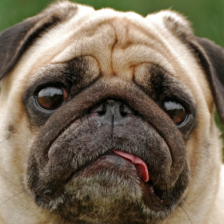

In [42]:
img_to_use_cropped  # this is same as Lasagne example.

In [52]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [53]:
from torch.nn import Parameter

input_img = Parameter(img_to_use_cropped_tensor.cuda(), requires_grad=True)
if input_img.grad is not None:
    input_img.grad.data.zero_()
model.zero_grad()
# wrap input in Parameter, so that gradients will be computed.
raw_score = model(input_img)
raw_score_numpy = raw_score.data.cpu().numpy()
print(raw_score_numpy.shape, np.argmax(raw_score_numpy.ravel()))
loss = raw_score.sum()
print('loss', loss)
# second time, there's no output anymore, due to lack of hook
# I didn't call it, as maybe zero_grad may have some interaction with it. Not sure. Just for safety.
# _ = alexnet(Variable(img_to_use_cropped_tensor.cuda()))

(1, 2) 1
loss tensor(-0.5560, device='cuda:0', grad_fn=<SumBackward0>)


In [55]:
# so, forward one time, and backward multiple times.
vis_param_dict['layer'] = 'classifier.6'
vis_param_dict['method'] = util.GradType.NAIVE
# which one coresponds
# this is the max one. I assume it's the correct one.
# indeed, it's correct.
# 55 is n01729977, corresponding to "green snake, grass snake".
vis_param_dict['index'] = 55
# alexnet gives 64, which is n01749939, or green mamba. not sure which one is correct.
loss.backward(retain_graph=True)

In [56]:
# adapted from <https://github.com/Lasagne/Recipes/blob/master/examples/Saliency%20Maps%20and%20Guided%20Backpropagation.ipynb>
def show_images(img_original, saliency, title):
    # convert from c01 to 01c
    print(saliency.min(), saliency.max(), saliency.mean(), saliency.std())
    saliency = saliency[::-1]  # to BGR
    saliency = saliency.transpose(1, 2, 0)
    
#     # put back std fixing.
#     saliency = saliency * np.array([ 0.229, 0.224, 0.225 ])
    
    # plot the original image and the three saliency map variants
    plt.figure(figsize=(10, 10), facecolor='w')
    plt.subplot(2, 2, 1)
    plt.title('input')
    plt.imshow(np.asarray(img_original))
    plt.subplot(2, 2, 2)
    plt.title('abs. saliency')
    plt.imshow(np.abs(saliency).max(axis=-1), cmap='gray')
    plt.subplot(2, 2, 3)
    plt.title('pos. saliency')
    plt.imshow((np.maximum(0, saliency) / saliency.max()))
    plt.subplot(2, 2, 4)
    plt.title('neg. saliency')
    plt.imshow((np.maximum(0, -saliency) / -saliency.min()))
    plt.suptitle(title)
    plt.show()

-0.00016864276 0.0002472937 -6.45435e-10 1.3157124e-05


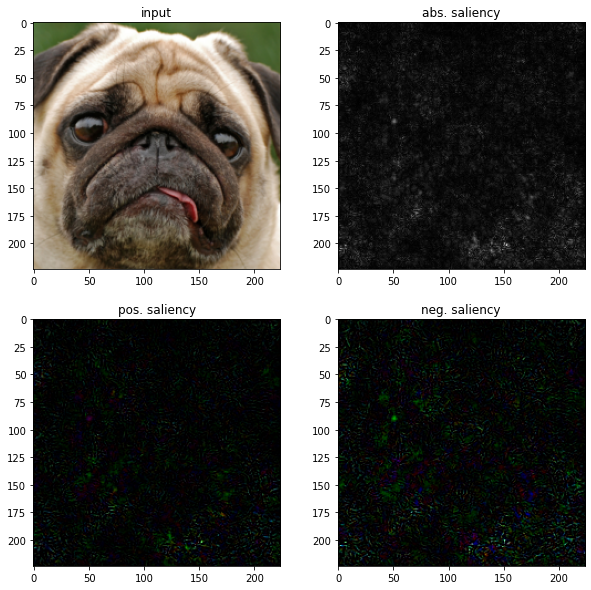

In [66]:
show_images(img_to_use_cropped, input_img.grad.data.cpu().numpy()[0], '')

-0.00016864273 0.00024729368 -6.454319e-10 1.3157123e-05


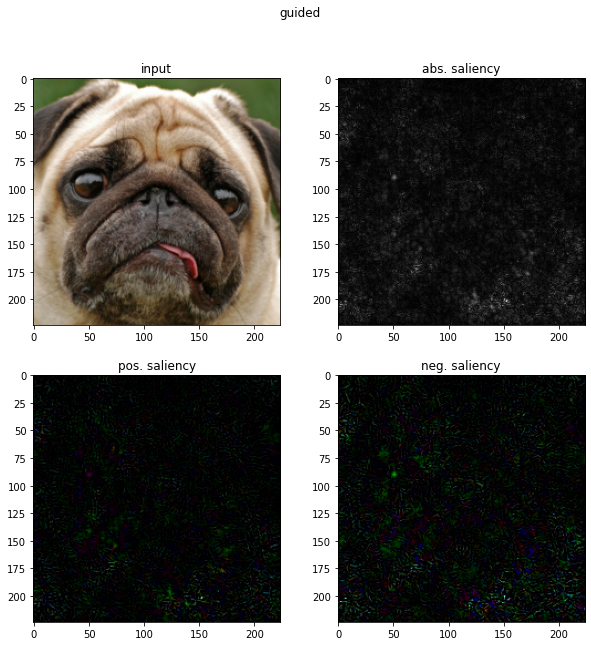

In [63]:
# so, forward one time, and backward multiple times.
vis_param_dict['method'] = util.GradType.GUIDED
# alexnet gives 64, which is n01749939, or green mamba. not sure which one is correct.
if input_img.grad is not None:
    input_img.grad.data.zero_()
model.zero_grad()
loss.backward(retain_graph=True)
show_images(img_to_use_cropped, input_img.grad.data.cpu().numpy()[0], 'guided')

-0.00016864276 0.0002472937 -6.45435e-10 1.3157124e-05


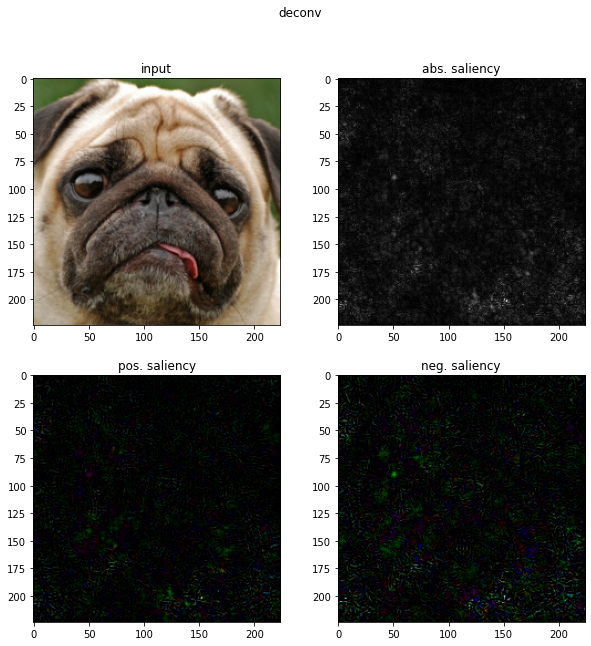

In [65]:
# so, forward one time, and backward multiple times.
vis_param_dict['method'] = util.GradType.DECONV
# alexnet gives 64, which is n01749939, or green mamba. not sure which one is correct.
if input_img.grad is not None:
    input_img.grad.data.zero_()
model.zero_grad()
loss.backward(retain_graph=True)
show_images(img_to_use_cropped, input_img.grad.data.cpu().numpy()[0], 'deconv')

In [ ]:
def dream(image, model, iterations, lr):
    """ Updates the image to maximize outputs for n iterations """
    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available else torch.FloatTensor
    image = preprocess(image).unsqueeze(0).cpu().data.numpy()
    image = Variable(Tensor(image), requires_grad=True)
    
    for i in range(iterations):
        model.zero_grad()
        out = model(image)
        loss = out.norm()
        if i % 10 == 0:
            print('iter: {}/{}, loss: {}'.format(i+1, iterations, loss.item()))
        loss.backward()
        avg_grad = np.abs(image.grad.data.cpu().numpy()).mean()
        norm_lr = lr / avg_grad
        image.data += norm_lr * image.grad.data
        image.data = clip(image.data)
        image.grad.data.zero_()
    return image.cpu().data.numpy()

In [ ]:
def diff_dream(image, model1, model2, iterations, lr):
    """ Updates the image to maximize outputs for n iterations """
    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available else torch.FloatTensor
    image = preprocess(image).unsqueeze(0).cpu().data.numpy()
    image = Variable(Tensor(image), requires_grad=True)
    
    for i in range(iterations):
        model1.zero_grad()
        model2.zero_grad()
        out1 = model1(image)
        out2 = model2(image)
        loss = out1.norm() / np.sqrt(np.prod(out1.shape)) - out2.norm() / np.sqrt(np.prod(out2.shape))
        if i % 10 == 0:
            print('iter: {}/{}, loss: {}'.format(i+1, iterations, loss.item()))
        loss.backward()
        avg_grad = np.abs(image.grad.data.cpu().numpy()).mean()
        norm_lr = lr / avg_grad
        image.data += norm_lr * image.grad.data
        image.data = clip(image.data)
        image.grad.data.zero_()
    return image.cpu().data.numpy()

In [ ]:
def deep_dream(image, model, iterations, lr, octave_scale, num_octaves):
    """ Main deep dream method """
    image = preprocess(image).unsqueeze(0).cpu().data.numpy()

    # Extract image representations for each octave
    octaves = [image]
    for _ in range(num_octaves - 1):
        octaves.append(nd.zoom(octaves[-1], (1, 1, 1 / octave_scale, 1 / octave_scale), order=1))

    detail = np.zeros_like(octaves[-1])
    for octave, octave_base in enumerate(tqdm.tqdm(octaves[::-1], desc="Dreaming")):
        if octave > 0:
            # Upsample detail to new octave dimension
            detail = nd.zoom(detail, np.array(octave_base.shape) / np.array(detail.shape), order=1)
        # Add deep dream detail from previous octave to new base
        input_image = octave_base + detail
        # Get new deep dream image
        dreamed_image = dream(input_image, model, iterations, lr)
        # Extract deep dream details
        detail = dreamed_image - octave_base

    return deprocess(dreamed_image)

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

#preprocess = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
preprocess = transforms.Compose([transforms.ToTensor()])

def deprocess(image_np):
    image_np = image_np.squeeze().transpose(1, 2, 0)
    image_np = image_np * std.reshape((1, 1, 3)) + mean.reshape((1, 1, 3))
    image_np = np.clip(image_np, 0.0, 255.0)
    return image_np

def clip(image_tensor):
    for c in range(3):
        m, s = mean[c], std[c]
        image_tensor[0, c] = torch.clamp(image_tensor[0, c], -m / s, (1 - m) / s)
    return image_tensor

In [ ]:
from PIL import Image
import scipy.ndimage as nd
from torch.autograd import Variable
import tqdm, os

# Load image
image = Image.open("/content/drive/MyDrive/Qiskit-Hackathon-Korea/qnn-visualization/images/dog.jpg")

# Set Models
#network = model
#layers = list(network.children())

#classical_model = nn.Sequential(*layers[: 9]) #Max: 9
classical_model = model_classical_cut
quantum_model = model

# Extract deep dream image
dreamed_image = dream(
        image,
        quantum_model,
        iterations=1000,
        lr=0.01
)

dreamed_image = np.transpose(dreamed_image, (0,2,3,1))
dreamed_image = dreamed_image[0]

# Save and plot image
#os.makedirs("outputs", exist_ok=True)
#filename = 'test'
plt.figure(figsize=(20, 20))
plt.imshow(dreamed_image)
#plt.imsave(f"outputs/output_{filename}", dreamed_image)
plt.show()

iter: 1/1000, loss: 0.50118088722229


TypeError: ignored

In [ ]:
quantum_dreamed_image = diff_dream(
        image,
        quantum_model,
        classical_model,
        iterations=500,
        lr=0.01
)

dreamed_image = quantum_dreamed_image

dreamed_image = np.transpose(dreamed_image, (0,2,3,1))
dreamed_image = dreamed_image[0]

# Save and plot image
#os.makedirs("outputs", exist_ok=True)
#filename = 'test'
plt.figure(figsize=(20, 20))
plt.imshow(dreamed_image)
#plt.imsave(f"outputs/output_{filename}", dreamed_image)
plt.show()

In [ ]:
classical_dreamed_image = diff_dream(
        image,
        classical_model,
        quantum_model,
        iterations=500,
        lr=0.01
)

dreamed_image = classical_dreamed_image

dreamed_image = np.transpose(dreamed_image, (0,2,3,1))
dreamed_image = dreamed_image[0]

# Save and plot image
#os.makedirs("outputs", exist_ok=True)
#filename = 'test'
plt.figure(figsize=(20, 20))
plt.imshow(dreamed_image)
#plt.imsave(f"outputs/output_{filename}", dreamed_image)
plt.show()